In [41]:
import pandas as pd
import importlib
import mpt_functions as mpt
importlib.reload(mpt)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from datetime import datetime, timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score



f1_start = "2020-04-18 00:00:00"
f1_finish = "2020-04-18 23:59:00"
f2_start = "2020-05-29 23:30:00"
f2_finish = "2020-05-30 06:00:00"
f3_start = "2020-06-05 10:00:00"
f3_finish = "2020-06-07 14:30:00"
f4_start = "2020-07-15 14:30:00"
f4_finish = "2020-07-15 19:00:00"

# **************************************************************************************************************#

path = "/Users/abdullahfurkanarslan/Desktop/metropt+3+dataset 2/MetroPT3(AirCompressor).csv"
df = mpt.get_the_data_and_convert_datetime(path)

#

df = mpt.drop_a_column(df, "Unnamed: 0")

#

df = df.assign(condition=0)
df = mpt.change_the_values_by_applying_a_time_filter(df, f1_start, f1_finish, "condition", 1)
df = mpt.change_the_values_by_applying_a_time_filter(df, f2_start, f2_finish, "condition", 1)
df = mpt.change_the_values_by_applying_a_time_filter(df, f3_start, f3_finish, "condition", 1)
df = mpt.change_the_values_by_applying_a_time_filter(df, f4_start, f4_finish, "condition", 1)




#

all_column_names = df.columns.to_list()

name_of_the_categorical_columns = ['COMP', 'DV_eletric', 'Towers',
       'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses']

name_of_the_numerical_columns =['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs',
       'Oil_temperature', 'Motor_current']

target_column = df["condition"]

#

df_scaled = mpt.scale_columns(df, name_of_the_numerical_columns)




datetime_column = df.columns[0]  # Adjust this if your datetime column isn't the first one

# Add month and week number columns
df_scaled['number_of_the_month'] = df_scaled[datetime_column].dt.month
df_scaled['number_of_the_week'] = df_scaled[datetime_column].dt.isocalendar().week
df_scaled["number_of_the_day"] = df_scaled[datetime_column].dt.isocalendar().day


df_scaled['number_of_the_month'] = df_scaled['number_of_the_month'].astype('float64')
df_scaled['number_of_the_week'] = (df_scaled['number_of_the_week'].astype('float64') % 4) + 1
df_scaled['number_of_the_day'] = df_scaled['number_of_the_day'].astype('float64')




def aggregate(df,aggregation_size, n1, n2, m3, n4, n5, n6, n7, n8):
    

    result1 = mpt.get_the_probabilities_with_logistic_regressionn(df, n1, n2, m3, n4, n5, n6, n7, n8, "yes")

    probabilities = result1[0]
    y_test = result1[1]

    #probabilities = mpt.get_the_probabilities_with_logistic_regressionn(df, n1, n2, m3, n4, n5, n6, n7, n8, "yes")[0]
    #y_test = mpt.get_the_probabilities_with_logistic_regressionn(df, n1, n2, m3, n4, n5, n6, n7, n8, "no")[1]
    df_ed = pd.DataFrame({"proba": probabilities, "condition": y_test})
    result = mpt.group_rows_by_condition(df_ed, aggregation_size)
    return result


def agg_new_deneme(df,aggregation_size, n1, n2, m3, n4, n5, n6, n7, n8, use1, use2, use3, use4, sliding_amount):

    result1 = mpt.get_the_probabilities_with_logistic_regressionn_new(df, n1, n2, m3, n4, n5, n6, n7, n8, "yes", use1, use2, use3, use4)

    probabilities = result1[0]
    y_test = result1[1]

    df_ed = pd.DataFrame({"proba": probabilities, "condition": y_test})
    result = mpt.group_rows_by_condition_sliding(df_ed, aggregation_size, sliding_amount)
    return result


def agg_random_forest(n, f, d, s, l, df, aggregation_size, n1, n2, m3, n4, n5, n6, n7, n8, use1, use2, use3, use4, sliding_amount, graph):


    result1 = mpt.get_the_probabilities_with_random_forest_new_new(n, f, d, s, l, df, n1, n2, m3, n4, n5, n6, n7, n8, "yes", use1, use2, use3, use4, graph)


    probabilities = result1[0]
    y_test =result1[1]
    
    df_ed = pd.DataFrame({"proba": probabilities, "condition": y_test})
    result = mpt.group_rows_by_condition_sliding(df_ed, aggregation_size, sliding_amount)

    feature_importances = result1[2]

    return result, feature_importances, y_test


def agg_single_tree(df,aggregation_size, n1, n2, m3, n4, n5, n6, n7, n8, use1, use2, use3, use4, sliding_amount):


    result1 = mpt.get_the_probabilities_with_single_tree(df, n1, n2, m3, n4, n5, n6, n7, n8, "yes", use1, use2, use3, use4)


    probabilities = result1[0]
    y_test =result1[1]
    
    df_ed = pd.DataFrame({"proba": probabilities, "condition": y_test})
    result = mpt.group_rows_by_condition_sliding(df_ed, aggregation_size, sliding_amount)
    return result



def plot_probabilities_by_condition(df, threshold): # tekrar yazılacak

    print(1)
    print(df)

    indices = np.arange(df.shape[0])
    
    # Create figure
    plt.figure(figsize=(8, 5))
    
    # Plot points with condition=0 and proba <= threshold in blue
    mask_0_below = (df['condition'] == 0) & (df['proba'] <= threshold)
    plt.scatter(indices[mask_0_below], df.loc[mask_0_below, 'proba'], 
                color='blue', alpha=0.7, label='condition=0')
    
    # Plot points with condition=0 and proba > threshold in red
    mask_0_above = (df['condition'] == 0) & (df['proba'] > threshold)
    plt.scatter(indices[mask_0_above], df.loc[mask_0_above, 'proba'], 
                color='red', alpha=0.7, label=f'condition=0, proba>{threshold}')
    
    # Plot points with condition=1 in black
    mask_1 = df['condition'] == 1
    plt.scatter(indices[mask_1], df.loc[mask_1, 'proba'], 
                color='black', alpha=0.7, label='condition=1')

    
    # Add labels and title
    plt.title('Probablity of Failure')
    plt.xlabel('Index')
    plt.ylabel('Probability')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()


df_back_up = df_scaled.copy()

                     Importance
DV_pressure            0.897749
number_of_the_day      0.073745
Oil_temperature        0.026597
H1                     0.001785
Reservoirs             0.000124
Motor_current          0.000000
number_of_the_month    0.000000
R-squareddd: 0.993468795293106
F-Value Like: 2180295.4551952416
model preditions
[0 0 0 ... 0 0 0]
model proba
[1.56715616e-04 1.56715616e-04 1.56715616e-04 ... 8.08396545e-06
 8.08396545e-06 8.08396545e-06]
        model_predictions  model_probablities
0                       0            0.000157
1                       0            0.000157
2                       0            0.000157
3                       0            0.000157
4                       0            0.000157
...                   ...                 ...
161090                  0            0.000008
161091                  0            0.000008
161092                  0            0.000008
161093                  0            0.000008
161094                  0     

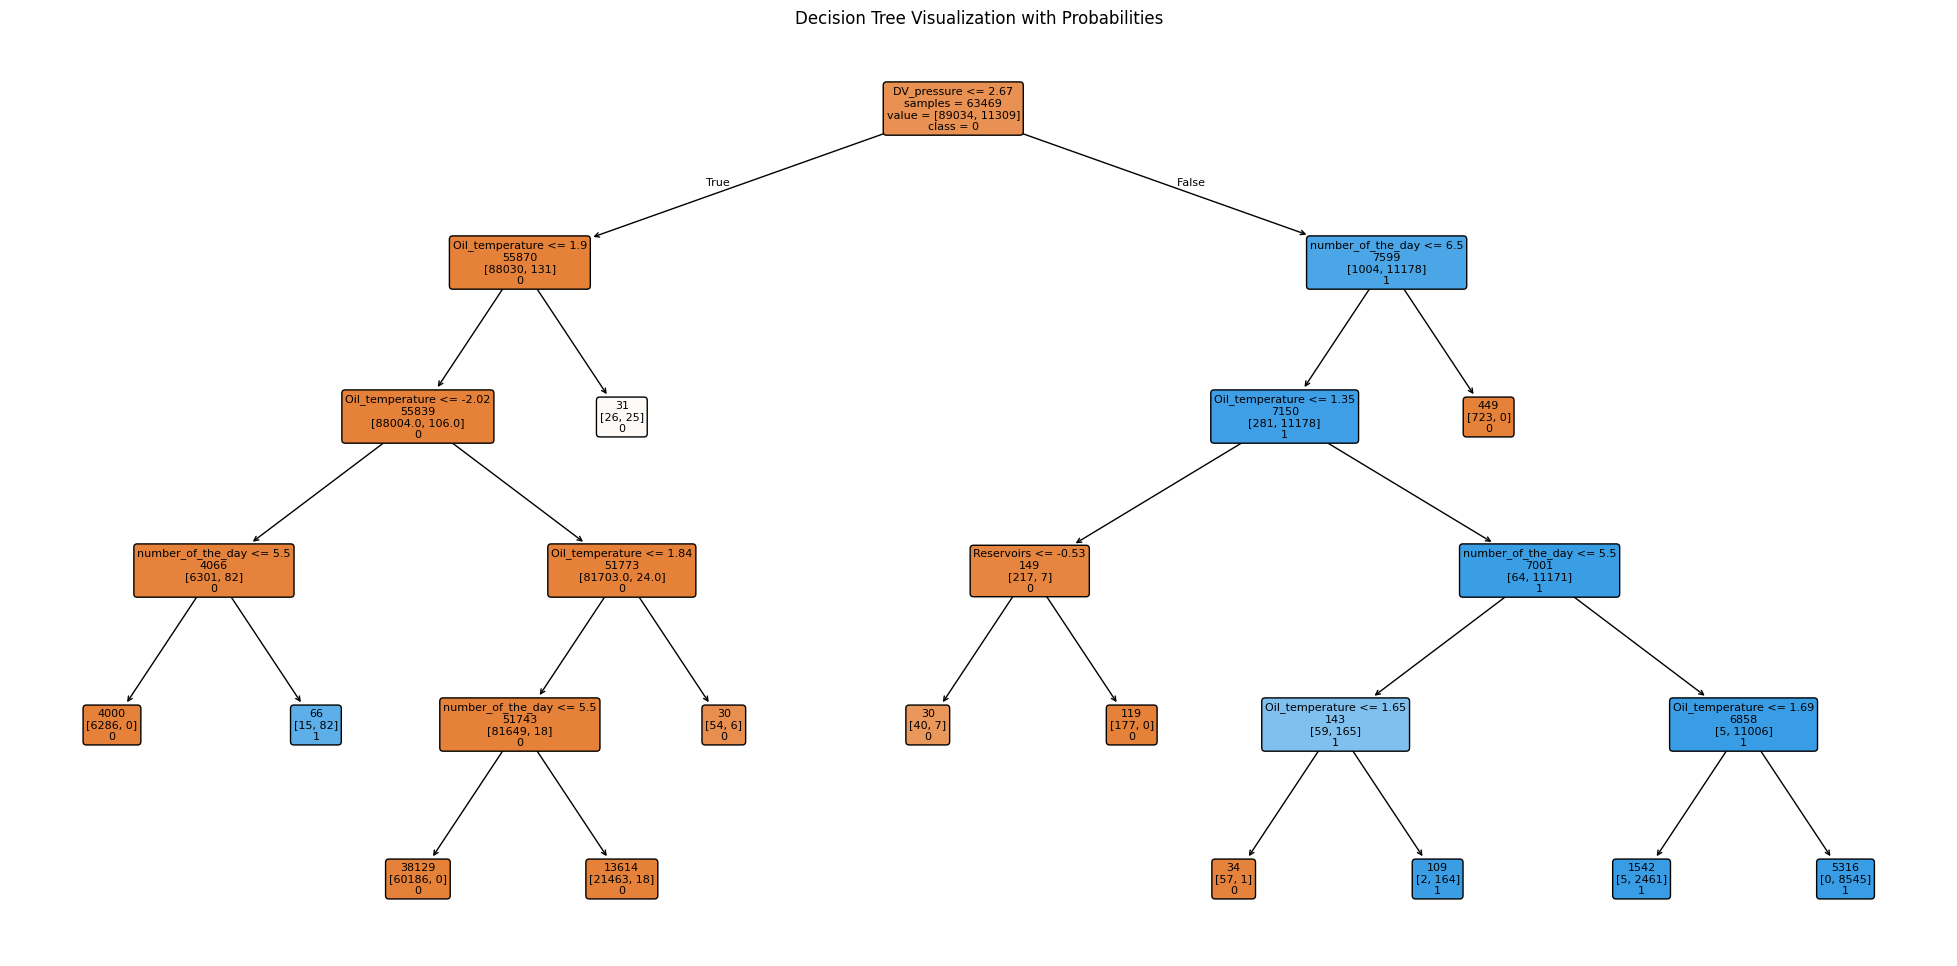

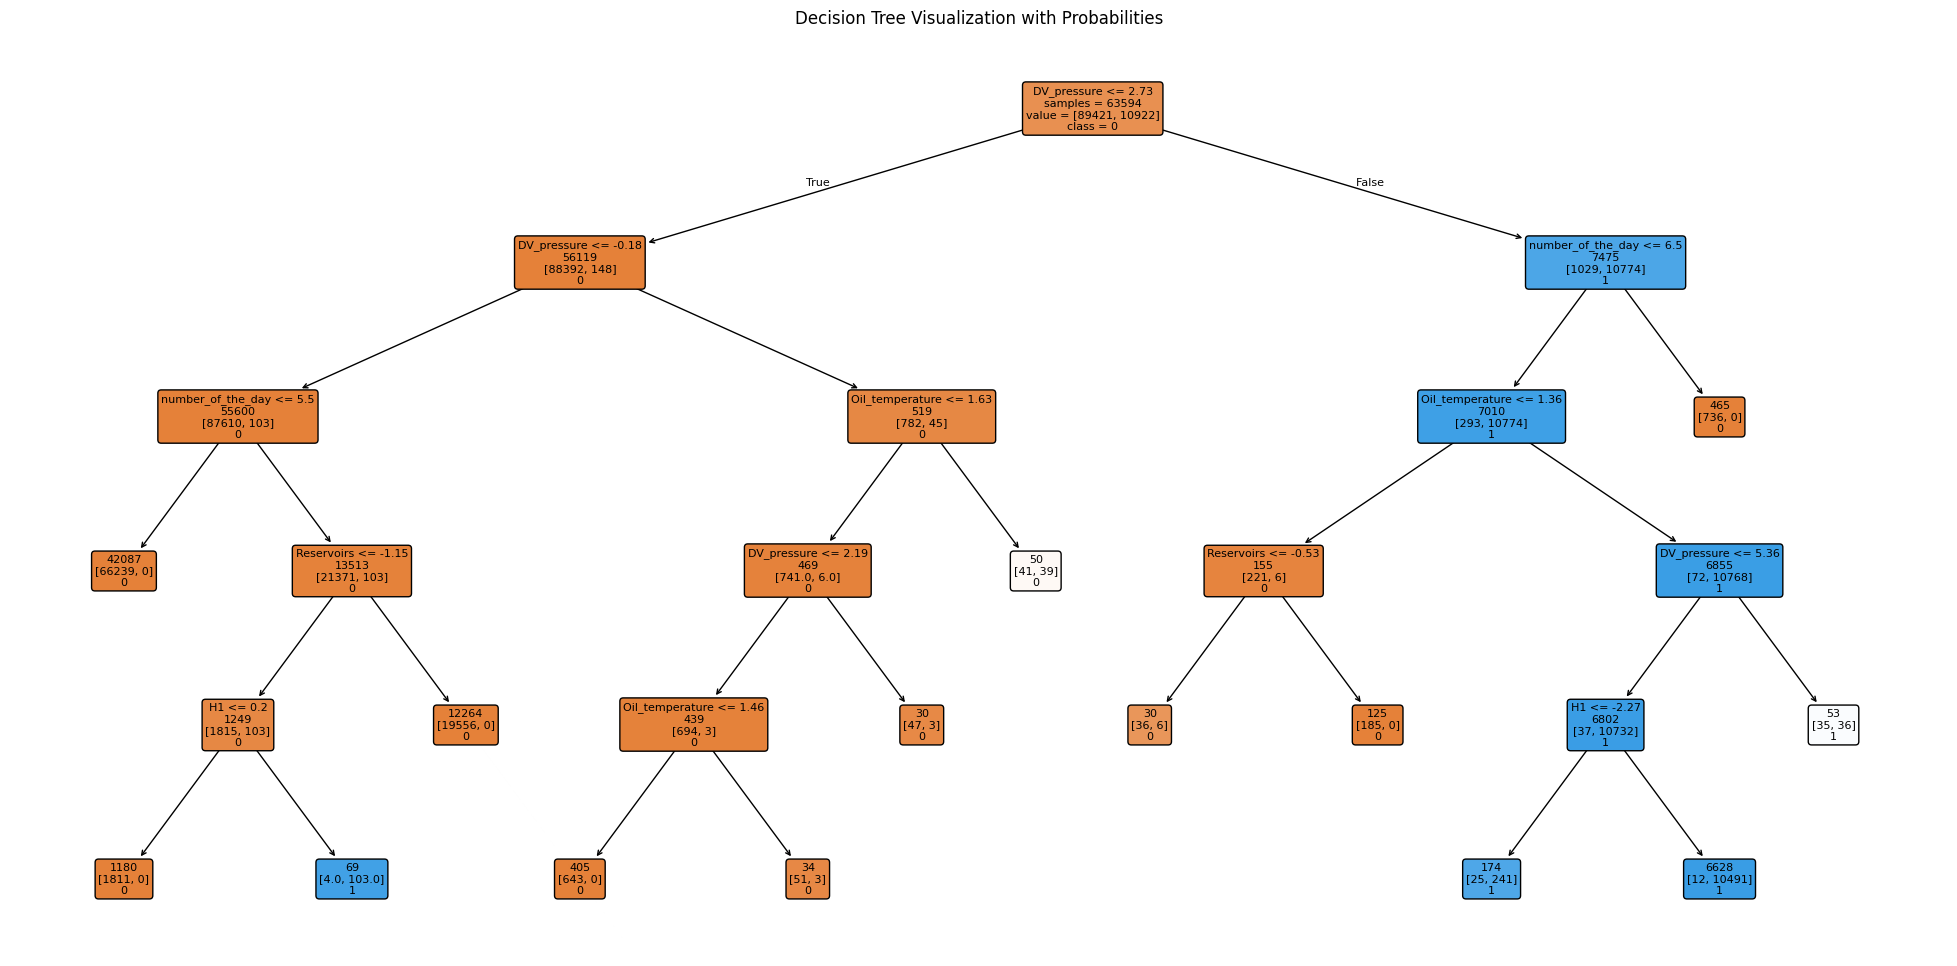

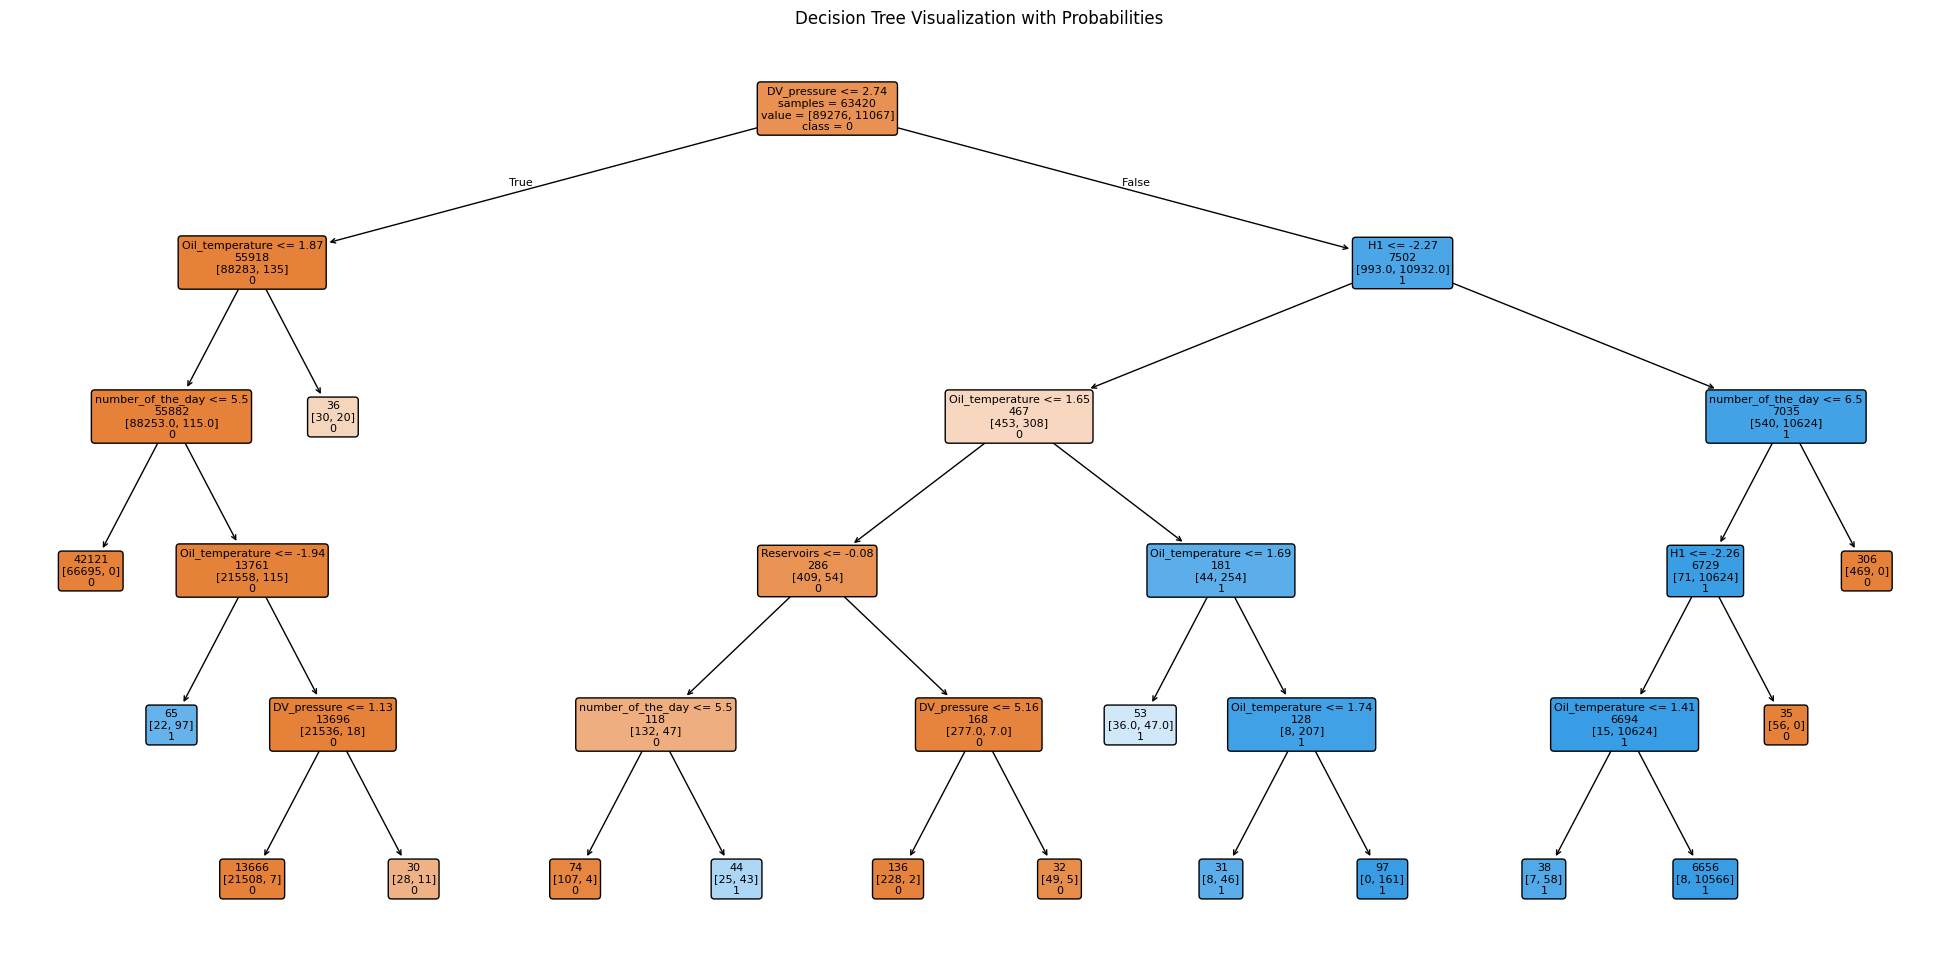

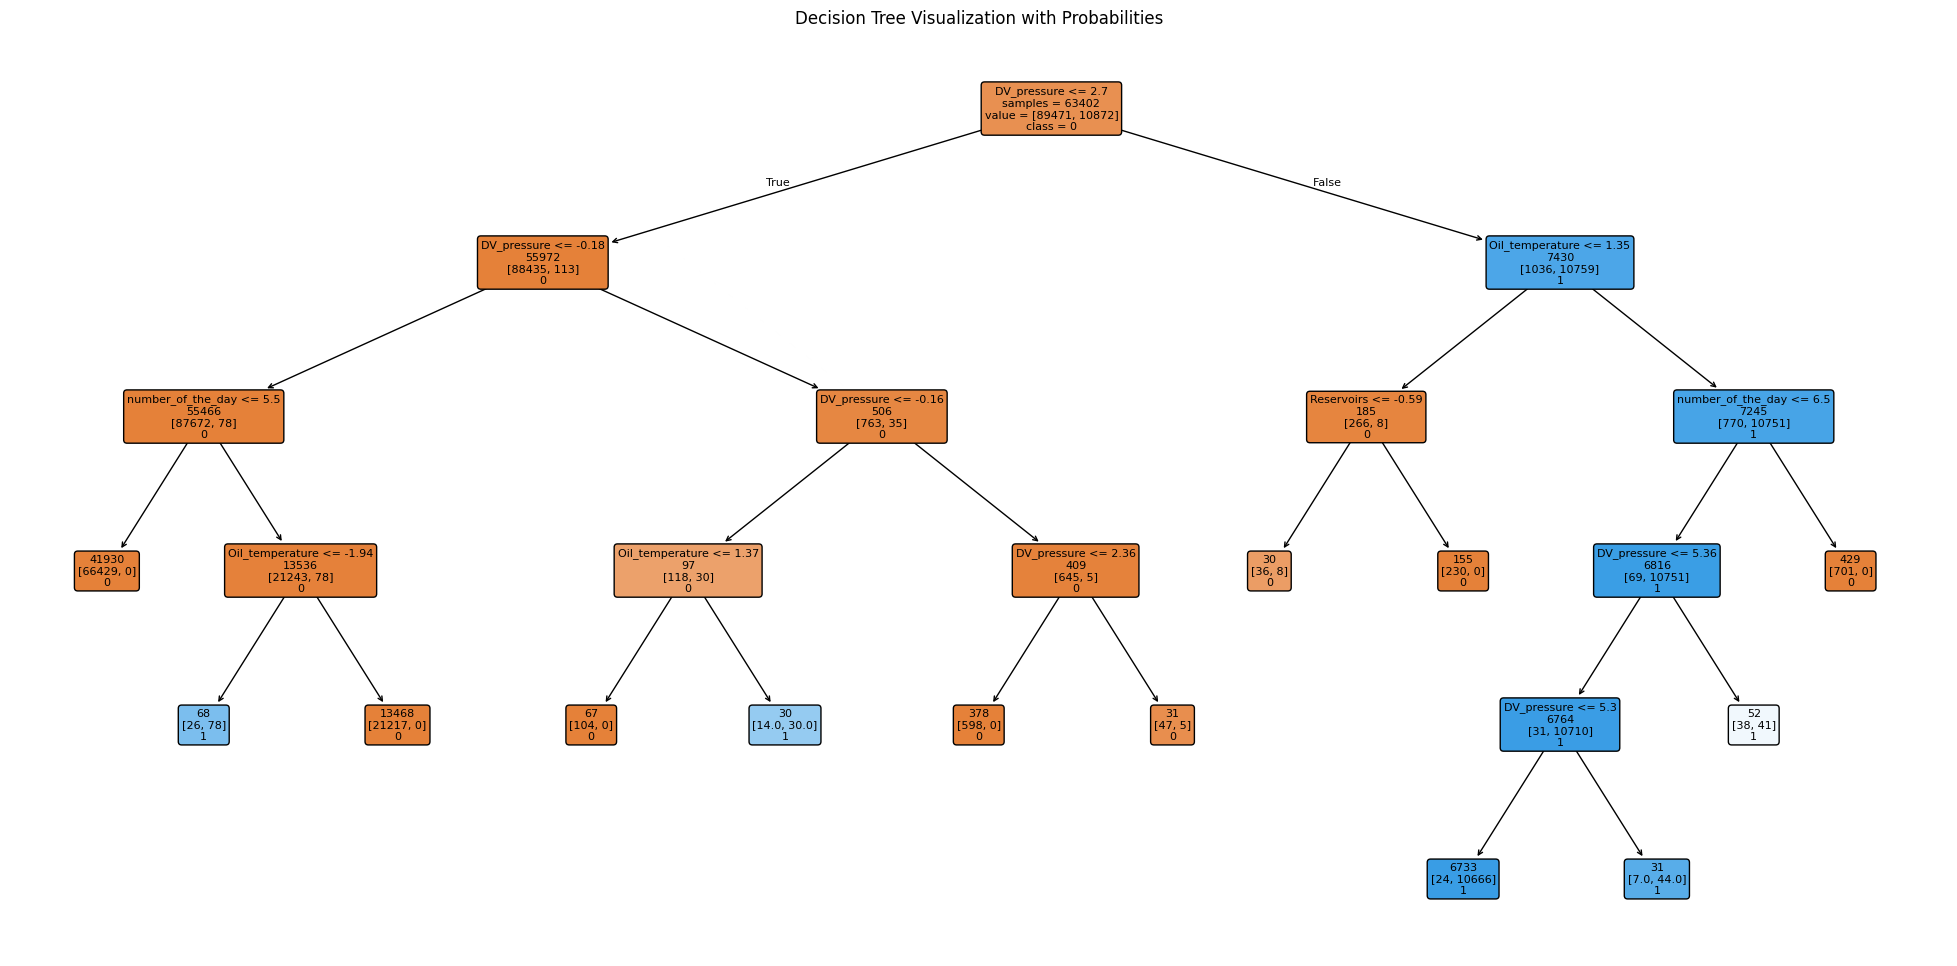

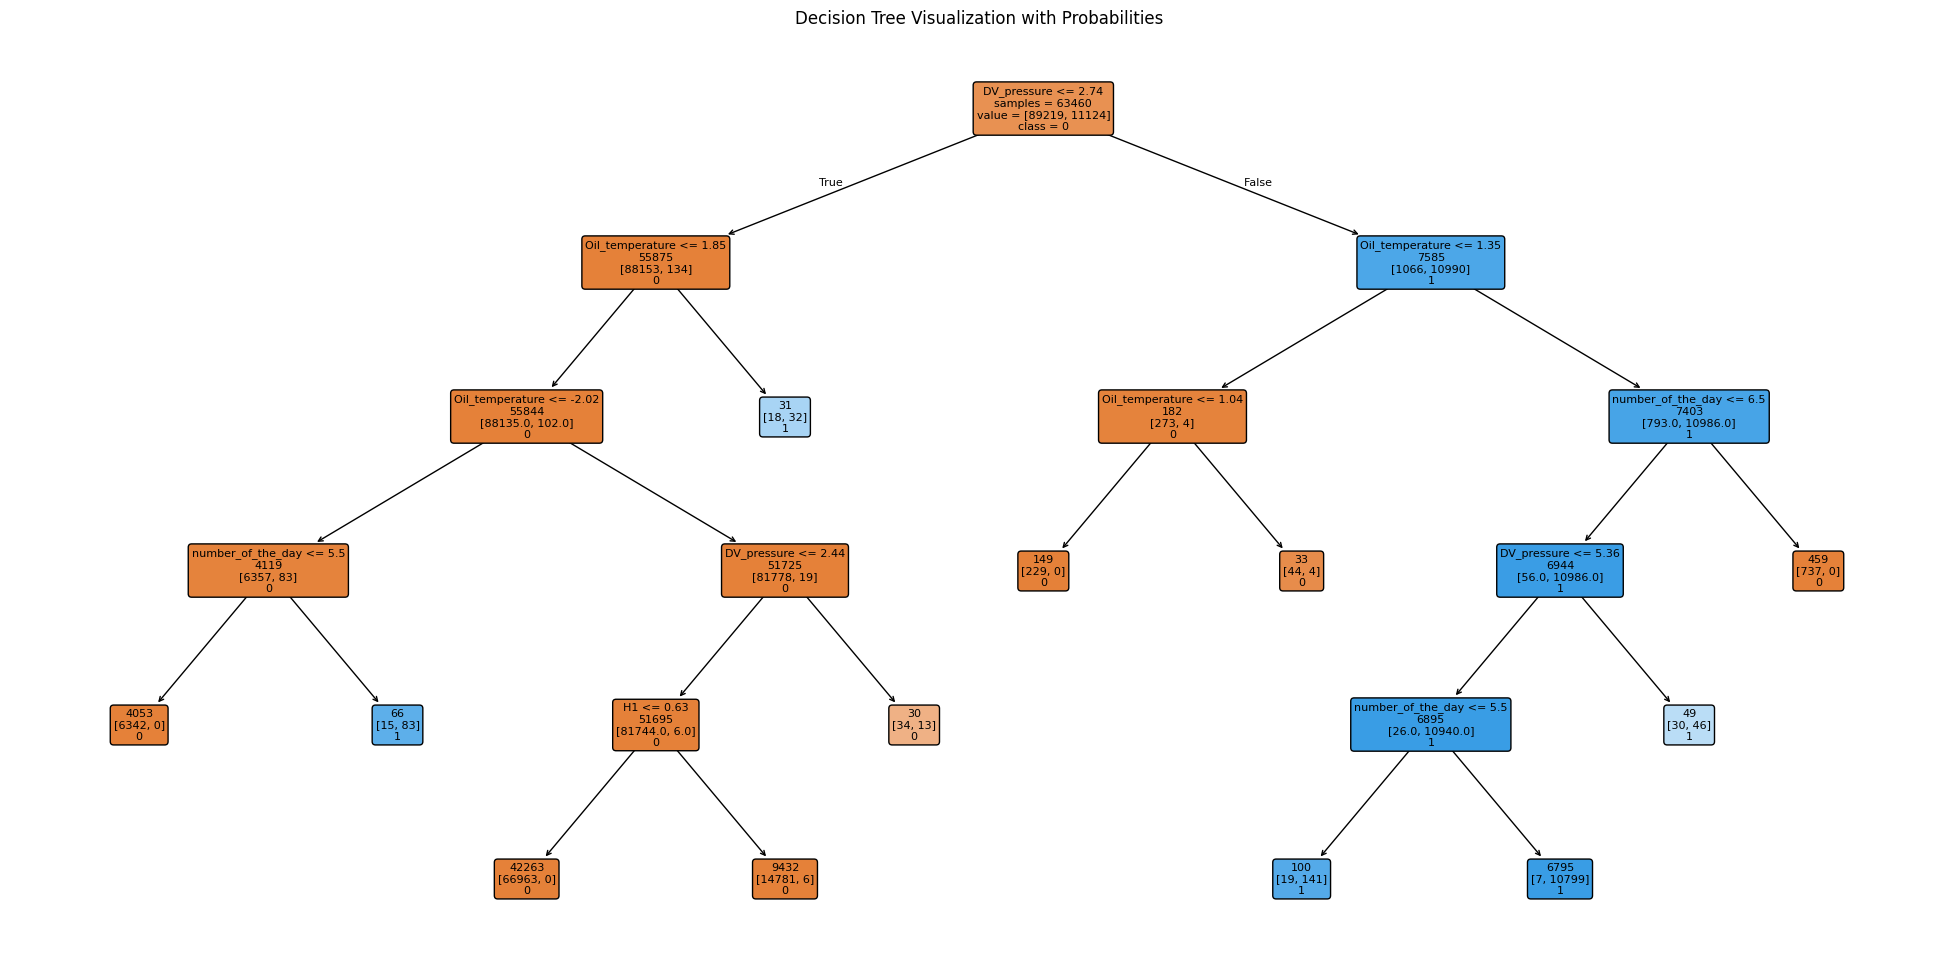

1
      group_id  start_row  end_row  row_count     proba  condition
0            0          0      399        400  0.000232          0
1            1        100      499        400  0.000236          0
2            2        200      599        400  0.000239          0
3            3        300      699        400  0.000240          0
4            4        400      799        400  0.000185          0
...        ...        ...      ...        ...       ...        ...
1603      1603     160300   160699        400  0.025044          0
1604      1604     160400   160799        400  0.028039          0
1605      1605     160500   160899        400  0.025815          0
1606      1606     160600   160999        400  0.023056          0
1607      1607     160700   161094        395  0.019077          0

[1608 rows x 6 columns]


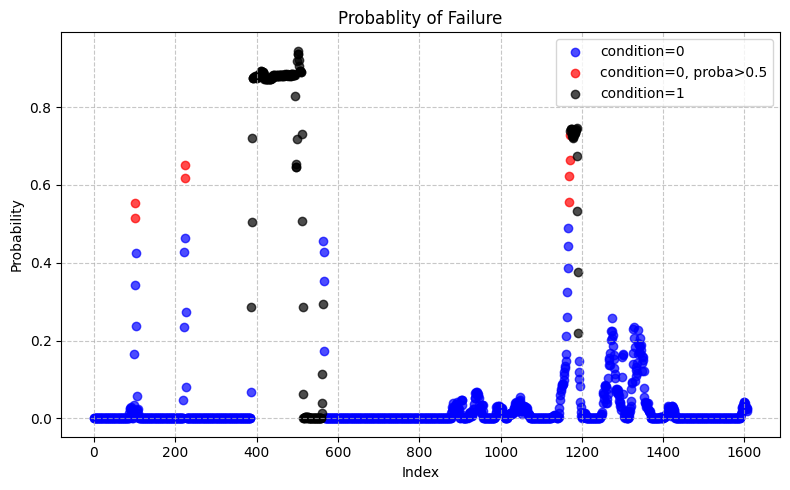

In [42]:
dataframe = df_back_up.copy()


dataframe = dataframe.drop(labels = [
    "DV_eletric", 
    "TP2",   
    "MPG", 
    "LPS", 
    "Pressure_switch", 
    "Oil_level", 
    "Caudal_impulses", 
    "number_of_the_week",
    "Towers",
    "TP3",
    "COMP",
], axis = 1)



def fit_the_model(i, j, k, l):
    
    aggregation_size = 400

    treshold_probability = 0.5

    aggregated_probabilities, f1, a = agg_random_forest(i, 5, j, k, l, dataframe, aggregation_size, 4, 2, 4, 2, 5, 5, 5, 5, "yes", "yes", "no", "no", 100, "yes")

    plot_probabilities_by_condition(aggregated_probabilities, treshold_probability)


fit_the_model(5, 5, 60, 30)

                     Importance
DV_pressure            0.897749
number_of_the_day      0.073745
Oil_temperature        0.026597
H1                     0.001785
Reservoirs             0.000124
Motor_current          0.000000
number_of_the_month    0.000000
R-squareddd: 0.993468795293106
F-Value Like: 2180295.4551952416
model preditions
[0 0 0 ... 0 0 0]
model proba
[0.00015672 0.00015672 0.00015672 ... 0.00015672 0.00015672 0.00015672]
        model_predictions  model_probablities
0                       0            0.000157
1                       0            0.000157
2                       0            0.000157
3                       0            0.000157
4                       0            0.000157
...                   ...                 ...
444443                  0            0.000157
444444                  0            0.000157
444445                  0            0.000157
444446                  0            0.000157
444447                  0            0.000157

[444448 

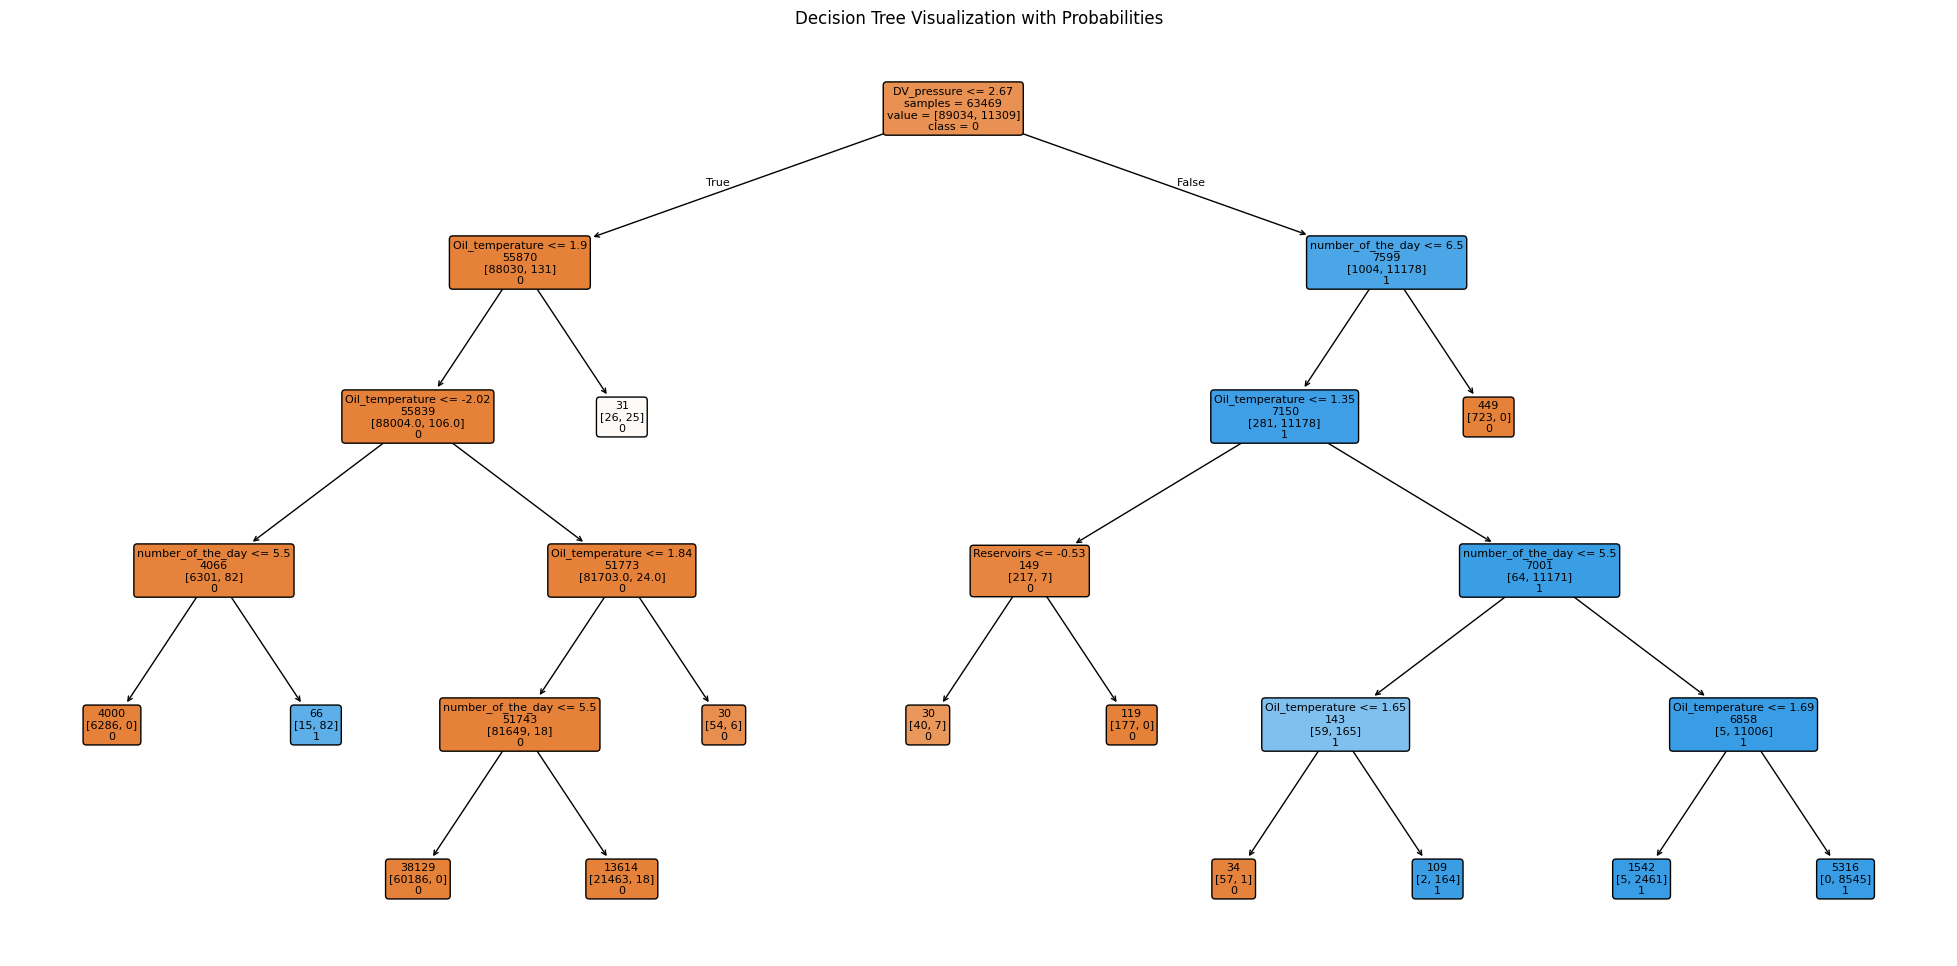

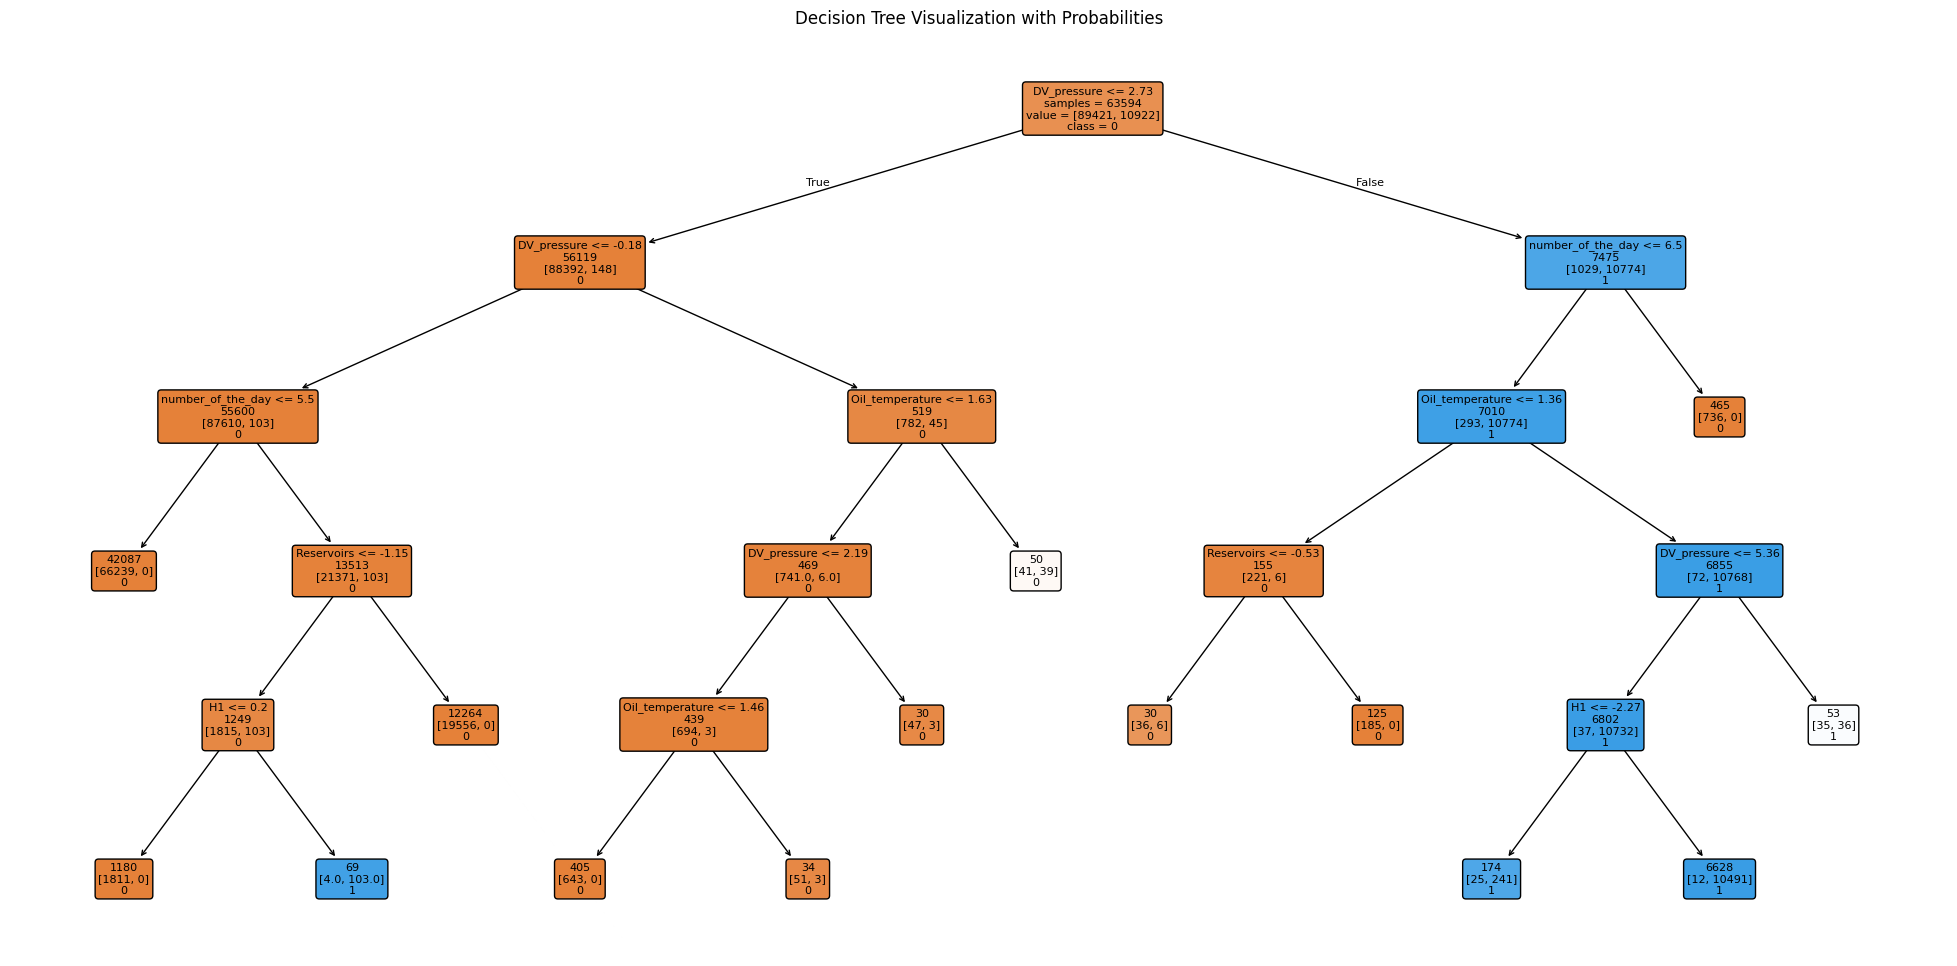

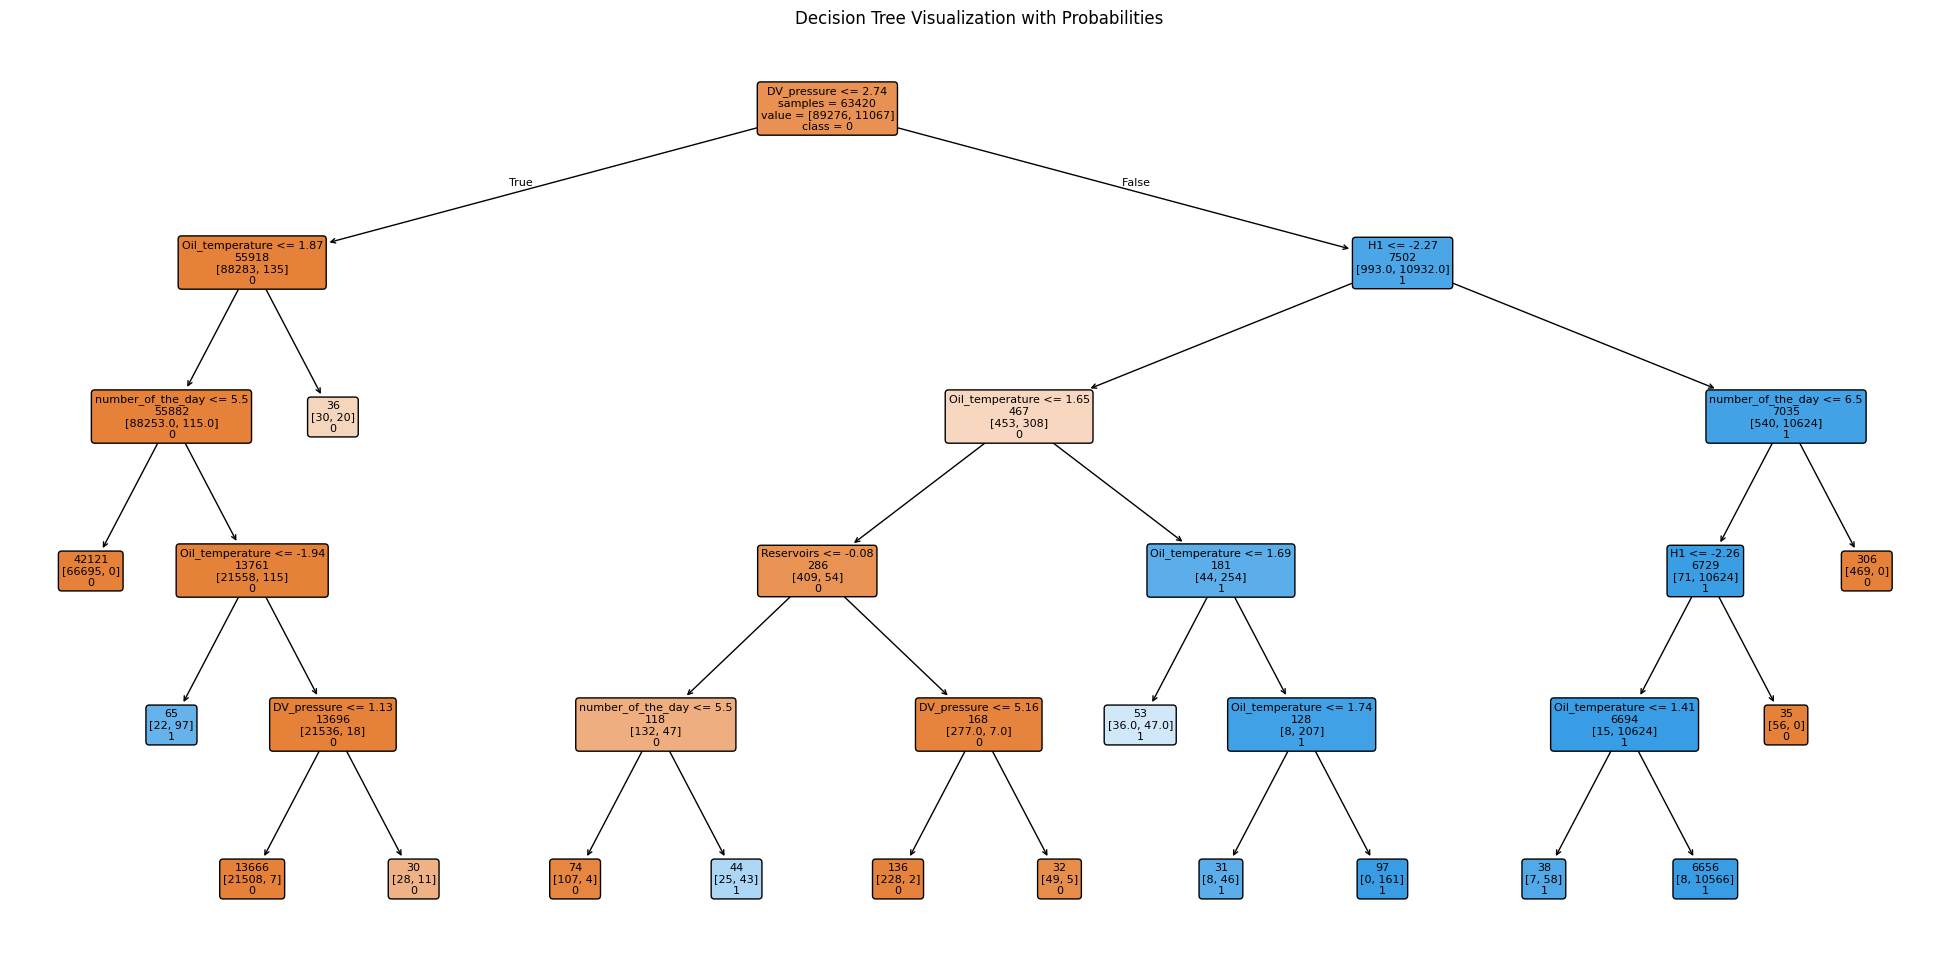

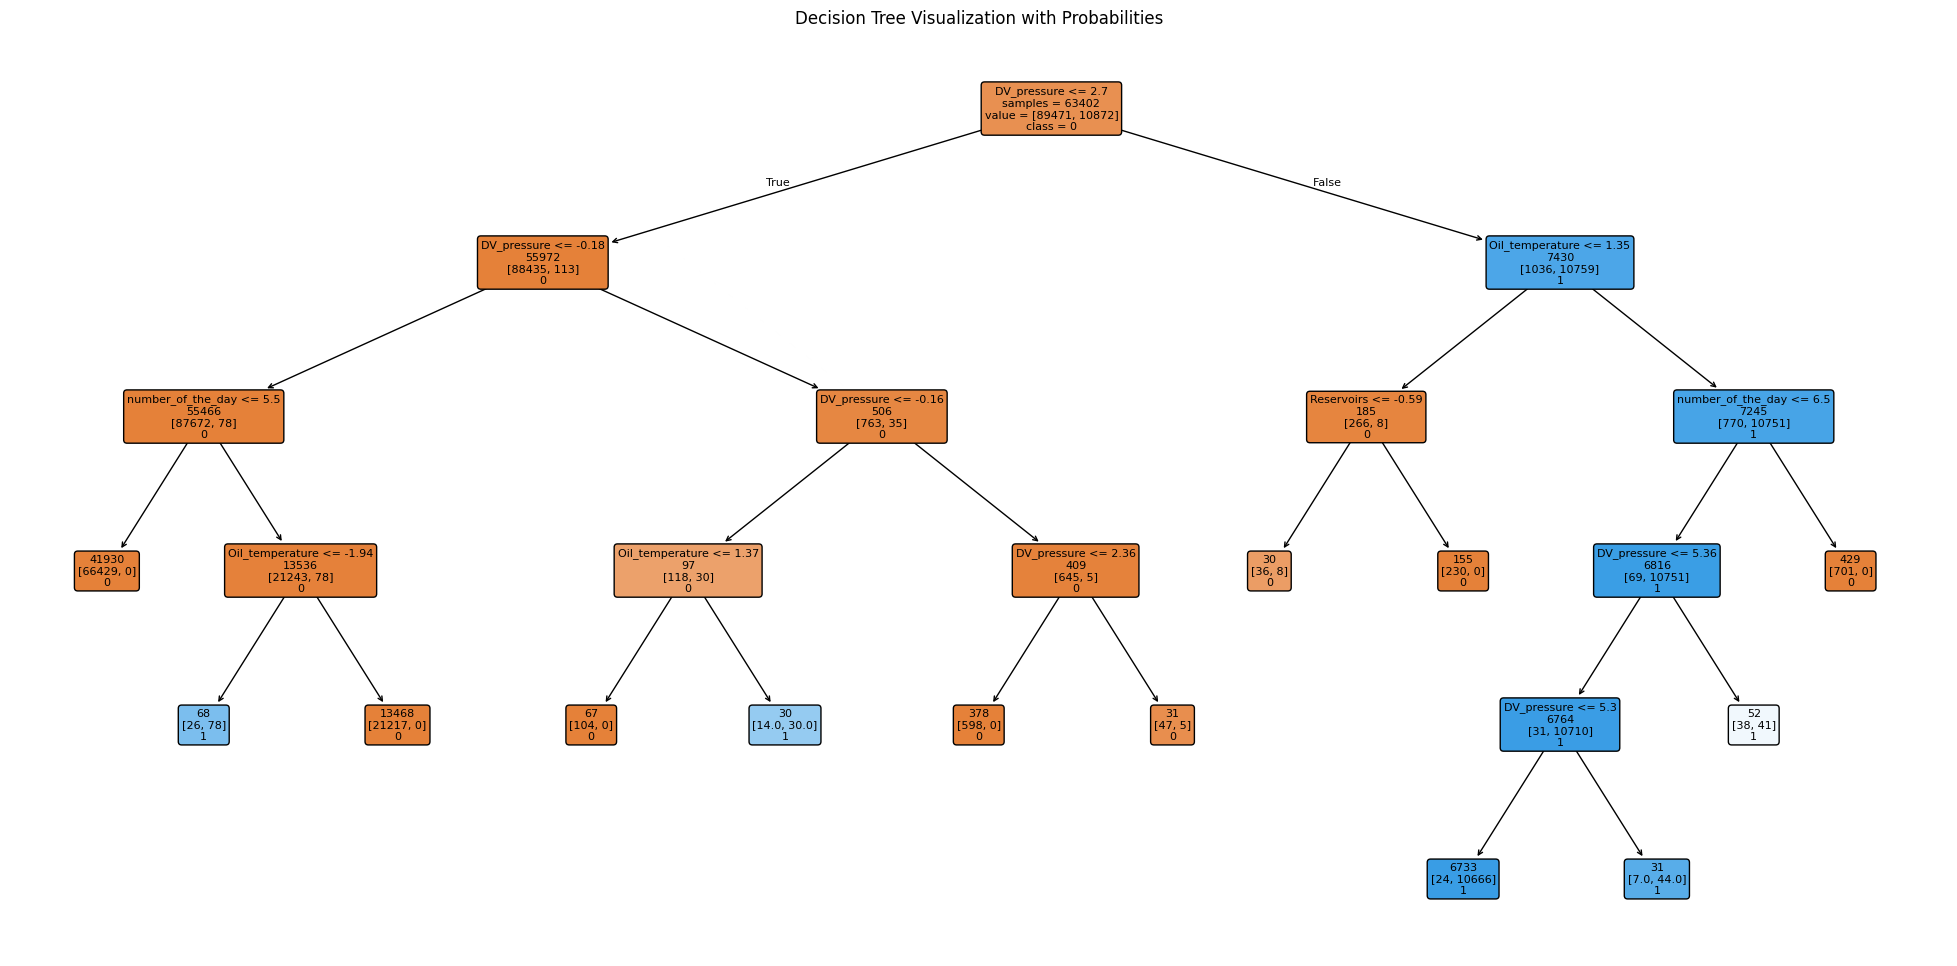

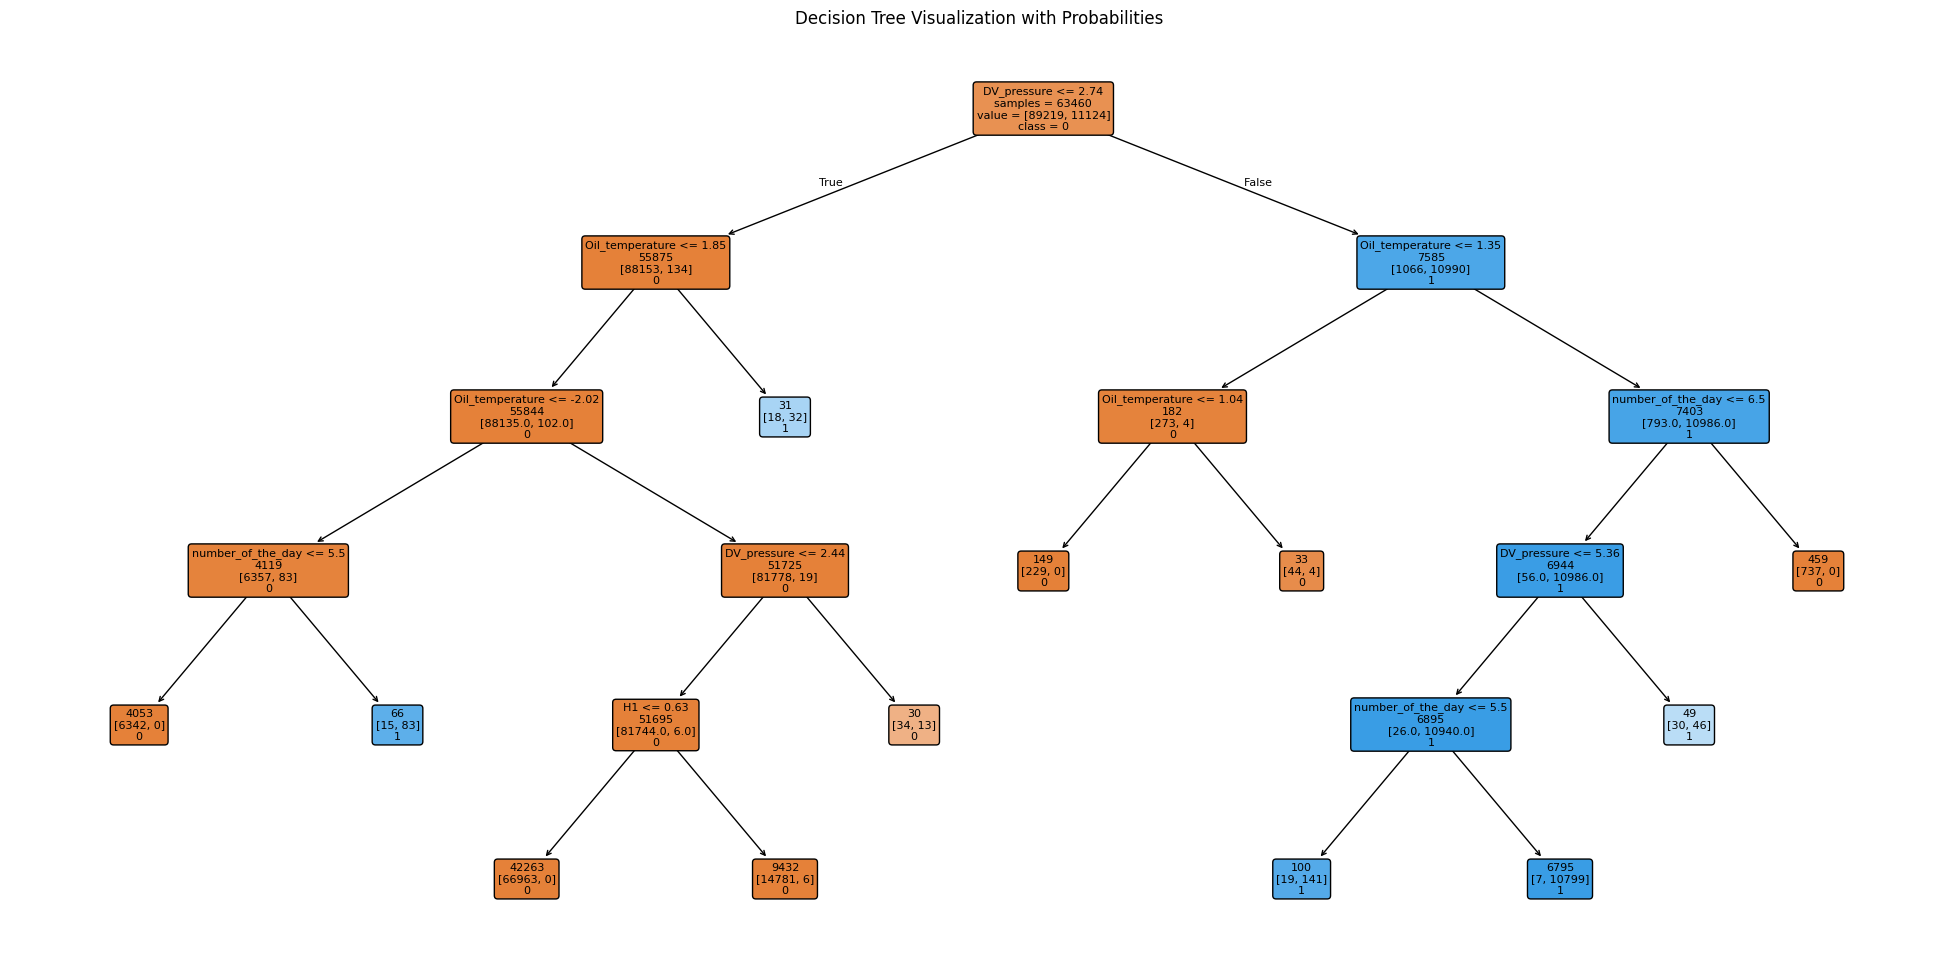

1
      group_id  start_row  end_row  row_count     proba  condition
0            0          0      399        400  0.000232          0
1            1        100      499        400  0.000236          0
2            2        200      599        400  0.000239          0
3            3        300      699        400  0.000240          0
4            4        400      799        400  0.000185          0
...        ...        ...      ...        ...       ...        ...
4437      4437     443700   444099        400  0.000270          0
4438      4438     443800   444199        400  0.000269          0
4439      4439     443900   444299        400  0.000673          0
4440      4440     444000   444399        400  0.000752          0
4441      4441     444100   444447        348  0.000833          0

[4442 rows x 6 columns]


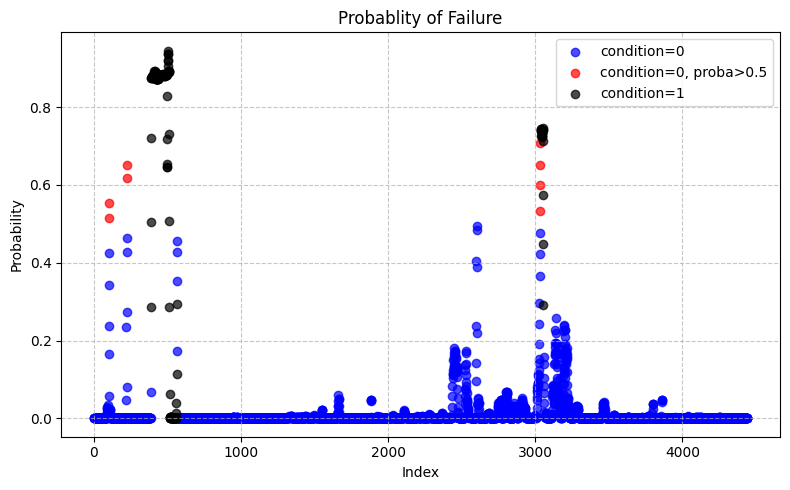

In [43]:
dataframe = df_back_up.copy()


dataframe = dataframe.drop(labels = [
    "DV_eletric", 
    "TP2",   
    "MPG", 
    "LPS", 
    "Pressure_switch", 
    "Oil_level", 
    "Caudal_impulses", 
    "number_of_the_week",
    "Towers",
    "TP3",
    "COMP",
], axis = 1)



def fit_the_model(i, j, k, l):
    
    aggregation_size = 400

    treshold_probability = 0.5

    aggregated_probabilities, f1, a = agg_random_forest(i, 5, j, k, l, dataframe, aggregation_size, 4, 2, 4, 2, 5, 18, 18, 18, "yes", "yes", "no", "no", 100, "yes")

    plot_probabilities_by_condition(aggregated_probabilities, treshold_probability)


fit_the_model(5, 5, 60, 30)